In [321]:
%matplotlib inline
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib, collections
from scipy.stats import norm
import imp, os, pickle
import warnings
from matplotlib import collections  as mc
from scipy.stats import poisson
warnings.filterwarnings("ignore")
from scipy.stats import norm
sns.set(style="white")
colors = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]

## Parameters

In [322]:
f = 0.1 #Mining rate
m = 200 #Number of voting chains
log_epsilon = 20 #Confirmation guarantee
pb = 2 #Number of proposal block
prob = [0.5, 0.5] # probability of choosing public proposal block 0 and 1

## Prism Latency Simulation

In [323]:
# Number of adverserial blocks in private at time t
def adverserial(t, beta, fv):
    x = np.arange(0,1000,1)
    mu = fv*t*beta/(1-beta)
    return poisson.pmf(x, mu)

#Probability that a vote with depth k will be removed when adversary has Z_t blocks in private
def p_k_t(k, Z_t,beta):
    ans = 0
    k = int(k)
    # print(k)
    for i in range(k):
        ans += Z_t[i]*np.power(beta/(1-beta), k - i)
    ans += np.sum(Z_t[k:])
    return ans

def runExp(m, log_epsilon, fv, pb, p):
    events = int(20000*log_epsilon)
    beta_array = np.array([0.1, 0.15, 0.2, 0.25, .3, .35, 0.4])
    time_array = np.zeros_like(beta_array)
    fv_effective = fv/(1.0+2*fv) #Forking
    exp_random_v = np.random.exponential(1/(m*fv_effective), size=events)
    chain_random_v = np.random.randint(m, size=events)
    proposal_block_selected_by_voter_chain = np.random.choice(pb, m, p = prob)
    for j, beta in enumerate(beta_array):
#         exponent = 0.8*(1-2*beta)/(1-beta)*np.log((1-beta)/beta)
        print('beta')
        print(beta)
        votes, votes_permanence_E, votes_permanence_V =  np.zeros(m), np.zeros(m),  np.zeros(m)
        time, mean, var  = 0, np.zeros(pb), np.zeros(pb) 
         
#        print('proposal_block_selected_by_voter_chain:')
#        print(proposal_block_selected_by_voter_chain)
        
        for i, tDiff in enumerate(exp_random_v):
            
            time += tDiff 
            
            # Adding vote on a random chain
            rChain = chain_random_v[i]
            votes[rChain] +=1
#            print(votes)
#            print(votes)
             
            
            #Solidified probability
            p_i = np.zeros(pb)
            Z_t = adverserial(time, beta, fv)
            p_i[proposal_block_selected_by_voter_chain[rChain]] = 1 - p_k_t(votes[rChain], Z_t, beta)

            #Updating the mean an variance
            mean[proposal_block_selected_by_voter_chain[rChain]] -= votes_permanence_E[rChain]
            var[proposal_block_selected_by_voter_chain[rChain]]  -= votes_permanence_V[rChain]
            votes_permanence_E[rChain] = p_i[proposal_block_selected_by_voter_chain[rChain]]
            votes_permanence_V[rChain] = p_i[proposal_block_selected_by_voter_chain[rChain]]*(1-p_i[proposal_block_selected_by_voter_chain[rChain]])
            mean[proposal_block_selected_by_voter_chain[rChain]] += votes_permanence_E[rChain]
            var[proposal_block_selected_by_voter_chain[rChain]]  += votes_permanence_V[rChain]
            
            # The block got confirmed
            V_estimate = mean - np.sqrt(2*var*log_epsilon)
            sorted_V_estimate = np.sort(V_estimate)
            
            # this is for checking no private proposal block gets highest votes
            # e.g., V->S transaction in one of the public proposer block, V->V in the private proposer block
            confirmation_policy_expression_1 = sorted_V_estimate[len(sorted_V_estimate) - 1] - (m - np.sum(sorted_V_estimate))
            
            # this is for checking the proposer block with second highest votes doesn't get rest of the votes
            #e.g., V->S transaction in one of the public proposer block and V->K in the other proposer block
            confirmation_policy_expression_2 = sorted_V_estimate[len(sorted_V_estimate) - 1] - sorted_V_estimate[len(sorted_V_estimate) - 2] - (m - np.sum(sorted_V_estimate))
            
            
            if (confirmation_policy_expression_1 > 0) and (confirmation_policy_expression_2 > 0):
                time_array[j] = time
                print('time')
                print(time)
                break

#        print('votes')
#        print(votes)
    return time_array

beta_array = np.array([0.1, 0.15, 0.2, 0.25, .3, .35, 0.4])
prism_ans = np.zeros_like(beta_array)
#T1: Time taken for a unique proposer block to refer the tx_block
prism_ans += np.power(np.e, 1*f)/f

#T2: Time taken for a proposer block to get confirmed
no_exp = 5
for i in range(no_exp):
    prism_ans += runExp(m, log_epsilon, f, pb, p)
prism_ans /= no_exp

beta
0.1
time
112.18257074720074
beta
0.15
time
174.57170900631277
beta
0.2
time
232.48377918634213
beta
0.25
time
310.03634962928743
beta
0.3
time
514.8694497333223
beta
0.35
time
1304.9526049710014
beta
0.4
time
4039.8628437997927
beta
0.1
time
112.81546273303658
beta
0.15
time
157.80392488897368
beta
0.2
time
207.84132411987198
beta
0.25
time
310.01304432729444
beta
0.3
time
527.6028241086947
beta
0.35
time
1019.6980490760684
beta
0.4
time
3094.204875216813
beta
0.1
time
93.26013423983143
beta
0.15
time
134.46071582661813
beta
0.2
time
218.84544450702197
beta
0.25
time
301.97886381827607
beta
0.3
time
500.2047899963391
beta
0.35
time
1034.0568361817468
beta
0.4
time
3927.6639143149787
beta
0.1
time
169.34120551867812
beta
0.15
time
208.09237558525507
beta
0.2
time
308.55289721478374
beta
0.25
time
530.9790265834067
beta
0.3
time
853.691275918614
beta
0.35
time
1683.6509679639773
beta
0.4
time
6608.695695211469
beta
0.1
time
133.72959126372038
beta
0.15
time
188.4650066828439
beta
0.

## Bitcoin Latency calculation

In [324]:
exponent = 0.8*(1-2*beta_array)/(1-beta_array)*np.log((1-beta_array)/beta_array)
bitcoin_ans= (log_epsilon+np.log2(150))/(exponent*f)

## Plot

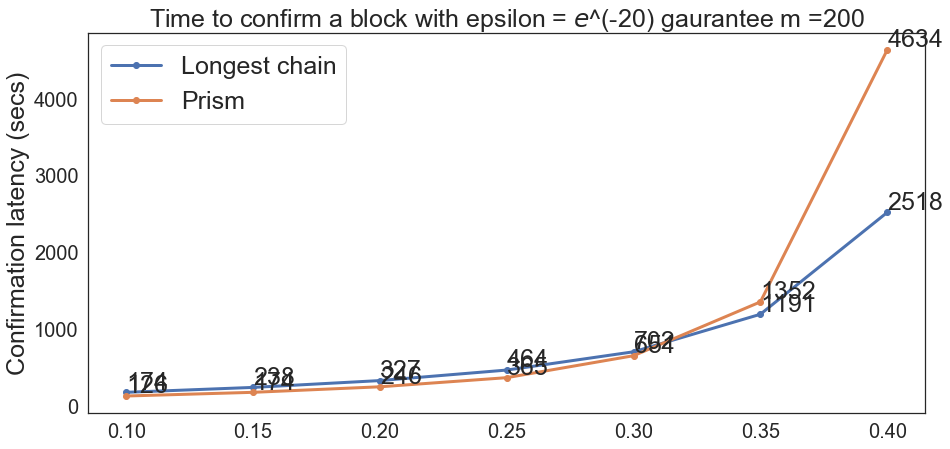

In [325]:
fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(111)

bitcoin_ans = bitcoin_ans.astype(int)
prism_ans = prism_ans.astype(int)
plt.plot(beta_array, bitcoin_ans, '-o', lw=3, label="Longest chain")
plt.plot(beta_array, prism_ans, '-o',lw=3, label="Prism")
for i in range(bitcoin_ans.shape[0]):
    ax.annotate(bitcoin_ans[i],xy=(beta_array[i],bitcoin_ans[i]+40), size=25)
    ax.annotate(prism_ans[i],xy=(beta_array[i],prism_ans[i]+40), size=25)
plt.ylabel("Confirmation latency (secs)", size=25)
# plt.xlabel("Beta", size=30)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.title("Time to confirm a block with epsilon = $e$^("+str(-log_epsilon)+") gaurantee m ="+str(m), size=25)
plt.legend(prop={'size': 25})
plt.show()


In [215]:
a = 'Yo'
b = 'So'
if (a == 'Yo') and (b == 'So'):
    print('Kudos')

Kudos
